## CSE5280 — Multi-Particle Animation with Social Forces
*   Task 1: Multi-particle simulation
*   Task 2: Social force models
*   Task 3: Visualization + animation
*   Task 4: Comparison isotropic vs anisotropic

Dependencies: numpy, matplotlib
    pip install numpy matplotlib

How to run:
    python multi_particle_social_forces.py

To Test Different Settings, pls change below parameters:
- Walls / environment geometry
- Initial particle positions
- Goal positions

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Tuple, Literal

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Array = np.ndarray

# ----------------------------
# Geometry helpers (2D)
# ----------------------------

def norm(x: Array, axis: Optional[int] = None, keepdims: bool = False) -> Array:
    return np.linalg.norm(x, axis=axis, keepdims=keepdims)

def unit(x: Array, eps: float = 1e-12) -> Array:
    n = norm(x, axis=-1, keepdims=True)
    return x / np.maximum(n, eps)

def closest_point_on_segment(p: Array, a: Array, b: Array) -> Tuple[Array, Array]:
    """
    Returns:
        cp: closest point on segment ab to point p
        t:  scalar parameter in [0,1] (projected)
    """
    ab = b - a
    ap = p - a
    denom = np.dot(ab, ab)
    if denom < 1e-12:
        return a.copy(), np.array(0.0)
    t = np.dot(ap, ab) / denom
    t_clamped = np.clip(t, 0.0, 1.0)
    cp = a + t_clamped * ab
    return cp, np.array(t_clamped)

In [10]:
# ----------------------------
# Cost functions
# ----------------------------

@dataclass
class GoalCost:
    """Quadratic attraction to goal."""
    w_goal: float = 1.0

    def value_and_grad(self, x: Array, goal: Array) -> Tuple[float, Array]:
        d = x - goal
        val = 0.5 * self.w_goal * float(np.dot(d, d))
        grad = self.w_goal * d
        return val, grad


@dataclass
class WallCost:
    """
    Soft wall penalty based on distance to line segments.
    Uses an exponential barrier-like cost:
        C_wall = w_wall * exp(-(d - r)/sigma)
    where:
        d = distance from particle center to wall
        r = particle radius (so penalty increases as wall gets closer than r)
        sigma = softness / decay length
    """
    w_wall: float = 5.0
    sigma: float = 0.15
    particle_radius: float = 0.08

    def value_and_grad(self, x: Array, wall_segments: List[Tuple[Array, Array]]) -> Tuple[float, Array]:
        total_val = 0.0
        total_grad = np.zeros(2, dtype=float)

        for (a, b) in wall_segments:
            cp, _ = closest_point_on_segment(x, a, b)
            v = x - cp
            d = float(norm(v))
            # distance from particle boundary to wall
            d_eff = d - self.particle_radius

            # cost: exp(-d_eff/sigma) -> large when near/penetrating
            e = np.exp(-d_eff / max(self.sigma, 1e-6))
            val = self.w_wall * e
            total_val += float(val)

            # gradient w.r.t x:
            # d = ||x-cp||, grad(d) = (x-cp)/||x-cp|| (ignoring cp dependence; ok for segments in practice)
            # grad(exp(-d_eff/sigma)) = exp(-d_eff/sigma) * (-1/sigma) * grad(d_eff)
            # grad(d_eff) ~ grad(d) = v/d
            if d > 1e-10:
                grad_dir = v / d
            else:
                # if exactly on wall, push in arbitrary direction
                grad_dir = np.array([1.0, 0.0])
            grad = self.w_wall * e * (-1.0 / max(self.sigma, 1e-6)) * grad_dir
            total_grad += grad

        return total_val, total_grad



In [14]:

# ----------------------------
# Social force models (pairwise penalties)
# ----------------------------

SocialModelName = Literal["quadratic_personal_space", "inverse_distance", "exponential"]

@dataclass
class SocialCostIsotropic:
    """
    Implements isotropic (distance-only) pairwise costs:

    1) Quadratic repulsion (personal space):
        C = 0.5*(R - d)^2 for d<=R else 0

    2) Inverse distance repulsion:
        C = 1/(d + eps)^p

    3) Exponential:
        C = A * exp(-d/B)
    """
    model: SocialModelName = "quadratic_personal_space"
    # shared parameters
    w_social: float = 1.0

    # quadratic personal space
    R: float = 0.35

    # inverse distance
    eps: float = 1e-3
    p: int = 2  # 1 or 2

    # exponential
    A: float = 1.0
    B: float = 0.35

    def phi_and_dphi(self, d: float) -> Tuple[float, float]:
        """Returns phi(d) and dphi/dd."""
        if self.model == "quadratic_personal_space":
            if d <= self.R:
                phi = 0.5 * (self.R - d) ** 2
                dphi = -(self.R - d)
                return self.w_social * phi, self.w_social * dphi
            return 0.0, 0.0

        if self.model == "inverse_distance":
            # phi = 1/(d+eps)^p
            denom = (d + self.eps)
            phi = 1.0 / (denom ** self.p)
            dphi = -self.p / (denom ** (self.p + 1))
            return self.w_social * phi, self.w_social * dphi

        if self.model == "exponential":
            # phi = A exp(-d/B)
            phi = self.A * np.exp(-d / self.B)
            dphi = phi * (-1.0 / self.B)
            return self.w_social * float(phi), self.w_social * float(dphi)

        raise ValueError(f"Unknown isotropic model: {self.model}")

    def pair_value_and_grad_wrt_xi(self, xi: Array, xj: Array) -> Tuple[float, Array]:
        """
        Returns:
            Csocial(xi,xj)
            grad wrt xi (∂C/∂xi)
        """
        r = xi - xj
        d = float(norm(r))
        if d < 1e-12:
            # prevent NaN: choose arbitrary direction
            r = np.array([1.0, 0.0])
            d = 1.0

        phi, dphi = self.phi_and_dphi(d)

        grad = dphi * (r / d)
        return phi, grad


@dataclass
class SocialCostAnisotropic:
    """
    Anisotropic (velocity-dependent) wrapper around an isotropic base phi(d):

    C_ani(i,j) = (1 + beta * max(0, vhat_i · (xj-xi)/||xj-xi||)) * phi(d)

    Note: This is a COST (penalty), so gradient descent will move particles in the direction
    that reduces it.
    """
    base: SocialCostIsotropic
    beta: float = 2.0
    eps_dir: float = 1e-12

    def pair_value_and_grad_wrt_xi(self, xi: Array, xj: Array, vi: Array) -> Tuple[float, Array]:
        r = xj - xi
        d = float(norm(r))
        if d < 1e-12:
            r = np.array([1.0, 0.0])
            d = 1.0
        rhat = r / d

        vhat = unit(vi, eps=self.eps_dir)
        forward = float(np.dot(vhat, rhat))
        gating = 1.0 + self.beta * max(0.0, forward)

        phi, dphi = self.base.phi_and_dphi(d)

        # Approximate gradient wrt xi:
        # C = gating * phi(d)
        # ∂C/∂xi ≈ gating * dphi * ∂d/∂xi, where ∂d/∂xi = (xi-xj)/d = -(rhat)
        # Careful: r = xj - xi, so xi-xj = -r => ∂d/∂xi = (xi-xj)/d = -rhat
        grad_distance = gating * dphi * (-rhat)

        # Optional: include gradient of gating wrt xi (depends on rhat). It improves fidelity but can be noisy.
        # For stability and grading, the distance gradient above is usually enough.
        val = gating * phi
        return float(val), grad_distance


# ----------------------------
# Simulation
# ----------------------------

@dataclass
class SimParams:
    dt: float = 0.05
    steps: int = 700
    alpha: float = 0.10            # gradient descent step size
    vel_smooth: float = 0.6        # for stable v estimate
    clip_step: float = 0.15        # max position step per iteration


@dataclass
class Environment:
    wall_segments: List[Tuple[Array, Array]]
    xlim: Tuple[float, float]
    ylim: Tuple[float, float]


@dataclass
class SystemState:
    X: Array          # (N,2) positions
    V: Array          # (N,2) velocities (estimated)
    goals: Array      # (N,2) goals


class MultiParticleSimulator:
    def __init__(
        self,
        env: Environment,
        goal_cost: GoalCost,
        wall_cost: WallCost,
        sim: SimParams,
        social_iso: Optional[SocialCostIsotropic] = None,
        social_ani: Optional[SocialCostAnisotropic] = None,
        use_anisotropic: bool = False,
        seed: int = 0,
    ):
        self.env = env
        self.goal_cost = goal_cost
        self.wall_cost = wall_cost
        self.sim = sim
        self.social_iso = social_iso
        self.social_ani = social_ani
        self.use_anisotropic = use_anisotropic
        self.rng = np.random.default_rng(seed)

    def step(self, state: SystemState) -> Tuple[SystemState, Dict[str, float]]:
        X, V, goals = state.X, state.V, state.goals
        N = X.shape[0]

        grads = np.zeros_like(X)
        cost_total = 0.0
        cost_goal_total = 0.0
        cost_wall_total = 0.0
        cost_social_total = 0.0

        # Compute gradients for each particle using positions from the SAME time step (simultaneous update)
        for i in range(N):
            xi = X[i]
            gi = goals[i]

            c_goal, g_goal = self.goal_cost.value_and_grad(xi, gi)
            c_wall, g_wall = self.wall_cost.value_and_grad(xi, self.env.wall_segments)

            grads[i] += (g_goal + g_wall)
            cost_goal_total += c_goal
            cost_wall_total += c_wall

        # Pairwise social interactions
        if self.use_anisotropic:
            if self.social_ani is None:
                raise ValueError("use_anisotropic=True but social_ani is None")
            for i in range(N):
                xi = X[i]
                vi = V[i]
                for j in range(N):
                    if j == i:
                        continue
                    xj = X[j]
                    c_s, g_s = self.social_ani.pair_value_and_grad_wrt_xi(xi, xj, vi)
                    grads[i] += g_s
                    cost_social_total += c_s
        else:
            if self.social_iso is None:
                raise ValueError("use_anisotropic=False but social_iso is None")
            for i in range(N):
                xi = X[i]
                for j in range(N):
                    if j == i:
                        continue
                    xj = X[j]
                    c_s, g_s = self.social_iso.pair_value_and_grad_wrt_xi(xi, xj)
                    grads[i] += g_s
                    cost_social_total += c_s

        cost_total = cost_goal_total + cost_wall_total + cost_social_total

        # Gradient descent update
        dX = -self.sim.alpha * grads

        # Clip step for numerical stability
        step_mag = norm(dX, axis=1, keepdims=True)
        dX = dX * np.minimum(1.0, self.sim.clip_step / np.maximum(step_mag, 1e-12))

        X_new = X + dX

        # Update velocity estimate (displacement / dt), smoothed
        v_inst = dX / max(self.sim.dt, 1e-12)
        V_new = self.sim.vel_smooth * V + (1.0 - self.sim.vel_smooth) * v_inst

        new_state = SystemState(X=X_new, V=V_new, goals=goals)
        metrics = {
            "cost_total": float(cost_total),
            "cost_goal": float(cost_goal_total),
            "cost_wall": float(cost_wall_total),
            "cost_social": float(cost_social_total),
        }
        return new_state, metrics

    def run(self, init_positions: Array, goals: Array) -> Tuple[Array, Dict[str, Array]]:
        N = init_positions.shape[0]
        state = SystemState(
            X=init_positions.copy(),
            V=np.zeros((N, 2), dtype=float),
            goals=goals.copy(),
        )

        traj = np.zeros((self.sim.steps, N, 2), dtype=float)
        costs = {k: np.zeros(self.sim.steps, dtype=float) for k in ["cost_total", "cost_goal", "cost_wall", "cost_social"]}

        for t in range(self.sim.steps):
            traj[t] = state.X
            state, m = self.step(state)
            for k in costs:
                costs[k][t] = m[k]

        return traj, costs


# ----------------------------
# Visualization utilities
# ----------------------------

def draw_environment(ax, env: Environment):
    ax.set_xlim(*env.xlim)
    ax.set_ylim(*env.ylim)
    ax.set_aspect("equal", adjustable="box")
    for (a, b) in env.wall_segments:
        ax.plot([a[0], b[0]], [a[1], b[1]], linewidth=2)


def animate_trajectories(
    env: Environment,
    traj: Array,
    goals: Array,
    title: str = "Multi-Particle Simulation",
    trail: int = 60,
    interval_ms: int = 30,
):
    steps, N, _ = traj.shape

    fig, ax = plt.subplots()
    ax.set_title(title)
    draw_environment(ax, env)

    # Goals
    ax.scatter(goals[:, 0], goals[:, 1], marker="*", s=120)

    # Particles
    scat = ax.scatter(traj[0, :, 0], traj[0, :, 1], s=50)

    # Trails
    lines = []
    for _ in range(N):
        ln, = ax.plot([], [], linewidth=1)
        lines.append(ln)

    def update(frame: int):
        X = traj[frame]
        scat.set_offsets(X)

        start = max(0, frame - trail)
        for i in range(N):
            seg = traj[start:frame + 1, i]
            lines[i].set_data(seg[:, 0], seg[:, 1])

        return [scat, *lines]

    ani = FuncAnimation(fig, update, frames=steps, interval=interval_ms, blit=True)
    plt.show()
    return ani


def plot_costs(costs: Dict[str, Array], title: str):
    fig, ax = plt.subplots()
    ax.set_title(title)
    for k, v in costs.items():
        ax.plot(v, label=k)
    ax.set_xlabel("step")
    ax.set_ylabel("cost")
    ax.legend()
    plt.show()


def visualize_single_particle_direction_field(
    env: Environment,
    social_iso: SocialCostIsotropic,
    x_other: Array,
    grid_x: Tuple[float, float] = (-1.0, 6.0),
    grid_y: Tuple[float, float] = (-1.0, 4.0),
    n: int = 25,
    title: str = "Predicted direction field (isotropic social cost)",
):
    """
    Task 4 (part): visualize the direction of motion induced by ONE nearby particle
    under isotropic interaction (distance-only). This plots -∇C_social wrt xi.
    """
    xs = np.linspace(grid_x[0], grid_x[1], n)
    ys = np.linspace(grid_y[0], grid_y[1], n)
    Xg, Yg = np.meshgrid(xs, ys)
    U = np.zeros_like(Xg)
    V = np.zeros_like(Yg)

    for iy in range(n):
        for ix in range(n):
            xi = np.array([Xg[iy, ix], Yg[iy, ix]])
            _, grad = social_iso.pair_value_and_grad_wrt_xi(xi, x_other)
            # predicted descent direction is -grad
            d = -grad
            U[iy, ix] = d[0]
            V[iy, ix] = d[1]

    fig, ax = plt.subplots()
    ax.set_title(title)
    draw_environment(ax, env)
    ax.scatter([x_other[0]], [x_other[1]], s=100)
    ax.quiver(Xg, Yg, U, V, angles="xy", scale_units="xy", scale=1.5)
    plt.show()


def visualize_single_particle_direction_field_anisotropic(
    env: Environment,
    social_ani: SocialCostAnisotropic,
    x_other: Array,
    vhat_fixed: Array,
    grid_x: Tuple[float, float] = (-1.0, 6.0),
    grid_y: Tuple[float, float] = (-1.0, 4.0),
    n: int = 25,
    title: str = "Predicted direction field (anisotropic, fixed velocity direction)",
):
    """
    Task 4 (part): visualize anisotropic direction field with a fixed v direction.
    """
    vhat_fixed = unit(np.asarray(vhat_fixed, dtype=float))

    xs = np.linspace(grid_x[0], grid_x[1], n)
    ys = np.linspace(grid_y[0], grid_y[1], n)
    Xg, Yg = np.meshgrid(xs, ys)
    U = np.zeros_like(Xg)
    V = np.zeros_like(Yg)

    for iy in range(n):
        for ix in range(n):
            xi = np.array([Xg[iy, ix], Yg[iy, ix]])
            vi = vhat_fixed  # magnitude irrelevant for direction here
            _, grad = social_ani.pair_value_and_grad_wrt_xi(xi, x_other, vi)
            d = -grad
            U[iy, ix] = d[0]
            V[iy, ix] = d[1]

    fig, ax = plt.subplots()
    ax.set_title(title)
    draw_environment(ax, env)
    ax.scatter([x_other[0]], [x_other[1]], s=100)
    ax.quiver(Xg, Yg, U, V, angles="xy", scale_units="xy", scale=1.5)
    # show fixed velocity direction arrow in corner
    ax.arrow(env.xlim[0] + 0.2, env.ylim[1] - 0.2, 0.6 * vhat_fixed[0], 0.6 * vhat_fixed[1],
             head_width=0.08, length_includes_head=True)
    plt.show()

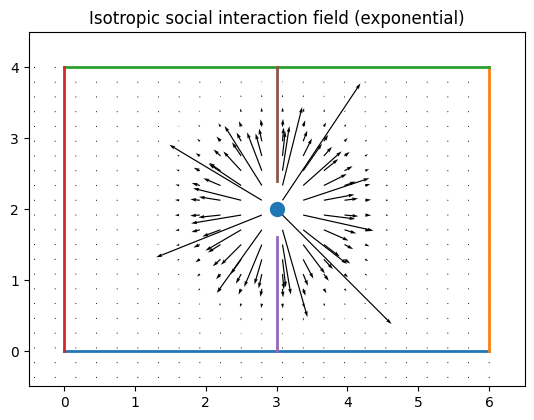

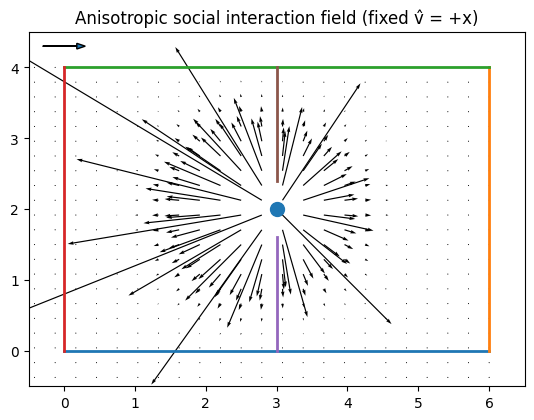

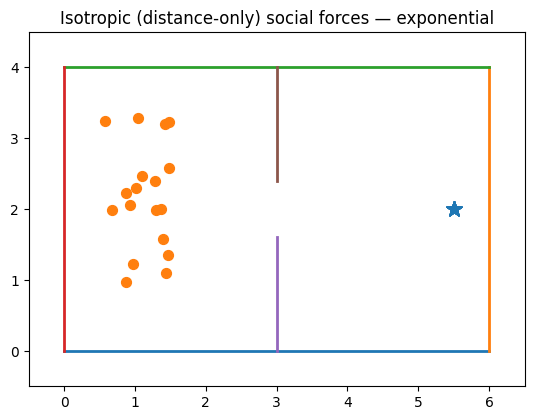

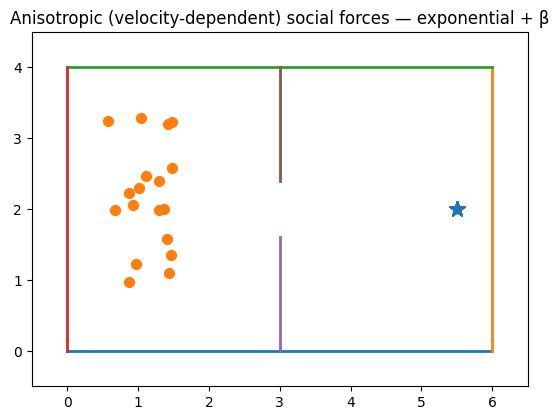

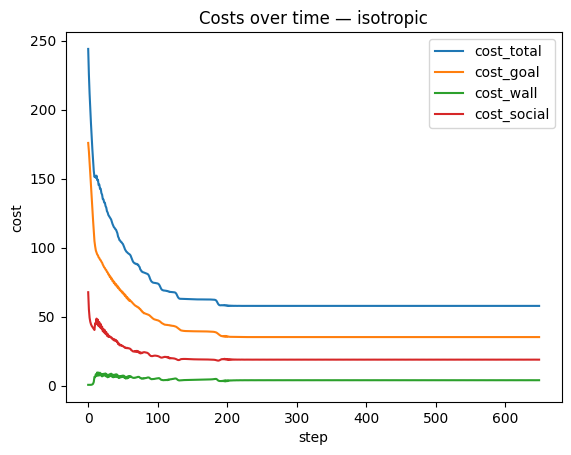

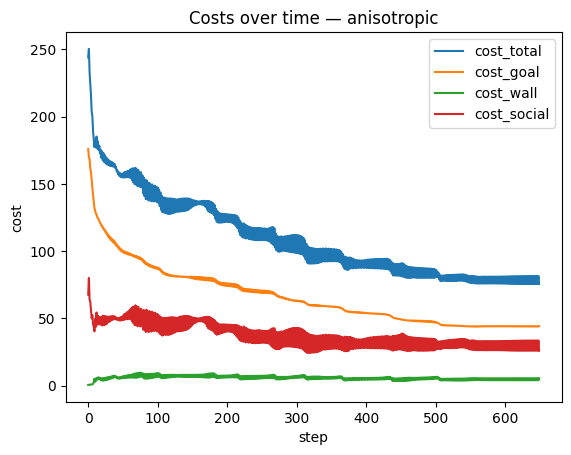

In [15]:
# ----------------------------
# Example environment + demo
# ----------------------------

def build_bottleneck_environment() -> Environment:
    """
    A simple environment that reveals congestion and deadlocks:
    - Outer rectangle
    - Interior 'wall' leaving a narrow corridor/bottleneck
    """
    # Outer box
    outer = [
        (np.array([0.0, 0.0]), np.array([6.0, 0.0])),
        (np.array([6.0, 0.0]), np.array([6.0, 4.0])),
        (np.array([6.0, 4.0]), np.array([0.0, 4.0])),
        (np.array([0.0, 4.0]), np.array([0.0, 0.0])),
    ]

    # Interior wall creating a bottleneck passage
    inner = [
        (np.array([3.0, 0.0]), np.array([3.0, 1.6])),
        (np.array([3.0, 2.4]), np.array([3.0, 4.0])),
    ]

    wall_segments = outer + inner
    return Environment(wall_segments=wall_segments, xlim=(-0.5, 6.5), ylim=(-0.5, 4.5))


def make_initial_conditions(N: int, env: Environment, seed: int = 1) -> Tuple[Array, Array]:
    """
    Start particles on the left aiming to the right, which creates bottleneck interaction.
    """
    rng = np.random.default_rng(seed)
    # cluster on the left side
    xs = rng.uniform(0.5, 1.5, size=N)
    ys = rng.uniform(0.6, 3.4, size=N)
    X0 = np.stack([xs, ys], axis=1)

    # common goal on right side
    goal = np.array([5.5, 2.0])
    goals = np.repeat(goal[None, :], repeats=N, axis=0)
    return X0, goals


def run_comparison_demo():
    env = build_bottleneck_environment()
    N = 18
    X0, goals = make_initial_conditions(N, env, seed=4)

    # Costs
    goal_cost = GoalCost(w_goal=1.0)
    wall_cost = WallCost(w_wall=10.0, sigma=0.12, particle_radius=0.10)

    # Social: implement >=2 isotropic models (here: quadratic and exponential).
    # We'll use exponential for the main comparison and keep quadratic as a quick swap option.
    social_iso_exp = SocialCostIsotropic(model="exponential", w_social=1.6, A=1.0, B=0.35)
    social_iso_quad = SocialCostIsotropic(model="quadratic_personal_space", w_social=1.3, R=0.35)

    social_ani_exp = SocialCostAnisotropic(base=social_iso_exp, beta=2.5)

    sim = SimParams(dt=0.05, steps=650, alpha=0.10, vel_smooth=0.55, clip_step=0.13)

    # --- Task 4: single-particle direction fields ---
    x_other = np.array([3.0, 2.0])
    visualize_single_particle_direction_field(
        env=env,
        social_iso=social_iso_exp,
        x_other=x_other,
        title="Isotropic social interaction field (exponential)",
    )
    visualize_single_particle_direction_field_anisotropic(
        env=env,
        social_ani=social_ani_exp,
        x_other=x_other,
        vhat_fixed=np.array([1.0, 0.0]),
        title="Anisotropic social interaction field (fixed v̂ = +x)",
    )

    # --- Task 1/2/3: simulate isotropic ---
    sim_iso = MultiParticleSimulator(
        env=env,
        goal_cost=goal_cost,
        wall_cost=wall_cost,
        sim=sim,
        social_iso=social_iso_exp,       # swap to social_iso_quad to compare isotropic models too
        social_ani=None,
        use_anisotropic=False,
        seed=0,
    )
    traj_iso, costs_iso = sim_iso.run(init_positions=X0, goals=goals)

    # --- Task 1/2/3: simulate anisotropic ---
    sim_ani = MultiParticleSimulator(
        env=env,
        goal_cost=goal_cost,
        wall_cost=wall_cost,
        sim=sim,
        social_iso=None,
        social_ani=social_ani_exp,
        use_anisotropic=True,
        seed=0,
    )
    traj_ani, costs_ani = sim_ani.run(init_positions=X0, goals=goals)

    # --- Task 3: animate both ---
    animate_trajectories(env, traj_iso, goals, title="Isotropic (distance-only) social forces — exponential")
    animate_trajectories(env, traj_ani, goals, title="Anisotropic (velocity-dependent) social forces — exponential + β")

    # --- Task 4: compare costs (optional but very helpful in report) ---
    plot_costs(costs_iso, "Costs over time — isotropic")
    plot_costs(costs_ani, "Costs over time — anisotropic")


if __name__ == "__main__":
    run_comparison_demo()

## Answers

### 1. How does directional dependence affect the symmetry of the social force field?

Directional dependence breaks the radial symmetry observed in isotropic (distance-only) social forces.
In the isotropic model, the interaction field is uniform in all directions around a particle because
the cost depends solely on inter-particle distance. This produces circular (radially symmetric) force
patterns, as seen in the isotropic interaction field visualization.

In contrast, the anisotropic model incorporates the particle’s velocity direction, weighting interactions
more strongly in front of the agent than behind it. As a result, the force field becomes asymmetric and
biased toward the direction of motion. The visualization with a fixed velocity $\hat{v}=+x$ shows
elongated and stronger influence regions ahead of the particle, while interactions behind it are reduced.
Therefore, directional dependence transforms a symmetric field into a forward-biased one that better
reflects realistic agent perception and response.


### 2. Does the anisotropic model reduce oscillations or deadlocks? Why?

Yes, the anisotropic model tends to reduce oscillations and potential deadlocks. In the isotropic case,
agents react equally to neighbors in all directions, which can lead to symmetric opposing forces. Such
symmetry often produces hesitation, lateral oscillations, or gridlock when multiple particles attempt
to pass through narrow regions simultaneously.

By contrast, the anisotropic model prioritizes obstacles and agents located in the forward direction
of motion. This directional bias encourages agents to continue progressing toward their goals while
mainly responding to conflicts ahead rather than behind. Consequently, agents are less likely to become
trapped in mutual repulsion cycles. The smoother, more gradual decrease of total cost over time in the
anisotropic simulation suggests more stable collective motion with reduced oscillatory behavior.


### 3. How does each model behave in narrow corridors or near bottlenecks?

In narrow corridors and bottleneck regions, the isotropic model often produces congestion because agents
exert equal repulsive forces in all directions. Particles approaching a constriction repel one another
symmetrically, which can cause clustering, slow progress, or temporary blockages as agents attempt to
avoid collisions without a clear priority of movement.

The anisotropic model behaves differently because agents primarily react to those in front of them.
This forward-focused interaction allows particles to align their movement through the corridor, forming
more coherent flow patterns. While congestion can still occur due to spatial constraints, the directional
bias generally enables smoother passage and reduces the likelihood of complete standstill. Thus, the
anisotropic model better captures realistic crowd dynamics in constrained environments.


### 4. What trade-offs arise when introducing velocity-dependent interactions?

Introducing velocity-dependent (anisotropic) interactions improves realism and stability but comes with
several trade-offs. First, the model becomes more complex because it requires estimating particle
velocities and computing directional weights in addition to distances. This increases computational
cost and implementation difficulty.

Second, anisotropic forces can produce stronger local interactions in front of agents, which may slow
overall progress toward goals, as reflected by the higher residual total cost compared to the isotropic
case. Third, sensitivity to parameter choices (such as the directional strength $\beta$) can affect
performance significantly; overly strong anisotropy may lead to excessive avoidance behavior.

Finally, while anisotropic models reduce symmetry-related artifacts, they may introduce new behaviors
such as lane formation or uneven distribution of space. Therefore, the trade-off is between simplicity
and symmetric behavior (isotropic) versus realism, stability, and directional awareness (anisotropic).